# MLP with floating point weights and baremetal C implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import src.python.dataset.yalefaces as yalefaces
import src.python.model.util as util

np.random.seed(99)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load dataset
### Load and normalize the raw dataset

In [3]:
X, y = yalefaces.load("dataset/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

### Compress dataset with PCA

In [4]:
num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

X_compressed = pca.transform(X)

### Split dataset into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

## Train MLP

In [6]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(165, 96, bias=True),
      torch.nn.ReLU(),
      torch.nn.Linear(96, 15, bias=True),
    )

  def forward(self, x):
    return self.layers(x)

In [7]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [8]:
train_accs= []
train_losses = []

for epoch in range(200):
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    error, num_samples = util.train(model, device, train_data, optimizer)
    loss = float(error)/float(num_samples)
    train_losses.append(loss)
    
    acc = util.test(model, device, train_data)
    train_accs.append(acc)

Text(0.5, 1.0, 'Accuracy')

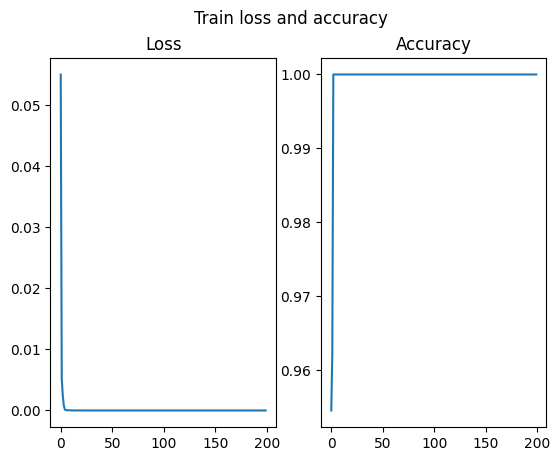

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Train loss and accuracy')

ax1.plot(train_losses)
ax1.set_title("Loss")

ax2.plot(train_accs)
ax2.set_title("Accuracy")

In [10]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = util.test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 84.85


## Export model weights as C code

In [11]:
model_params=model.state_dict()

In [12]:
print(model_params)

OrderedDict([('layers.0.weight', tensor([[-2.9215e-02, -7.5896e-02, -2.3351e-02,  ...,  6.9751e-08,
         -8.6451e-08,  5.4451e-08],
        [-5.7214e-02, -5.7759e-02, -5.4866e-03,  ...,  4.0329e-08,
         -1.0368e-08,  2.7128e-09],
        [ 6.5338e-02, -6.4358e-04,  2.0575e-02,  ..., -2.2563e-09,
         -1.5429e-08,  1.8309e-07],
        ...,
        [ 4.9583e-02, -2.0581e-03, -4.0346e-02,  ..., -7.3698e-08,
          9.2030e-09, -1.5519e-08],
        [-1.3617e-02, -1.4954e-02,  1.3239e-01,  ...,  4.7438e-08,
          2.0360e-07,  2.1893e-08],
        [ 5.4411e-02, -8.0388e-02,  3.5239e-02,  ...,  2.6136e-08,
         -9.1189e-09, -2.9159e-08]])), ('layers.0.bias', tensor([-0.0009, -0.0299, -0.0130, -0.0185, -0.0349,  0.0083, -0.0006, -0.0184,
         0.0581,  0.0055,  0.0154, -0.0031,  0.0325,  0.0020,  0.0270,  0.0037,
         0.0287, -0.0316, -0.0266,  0.0181, -0.0742, -0.0079, -0.0803, -0.0351,
         0.0312,  0.0191,  0.0421, -0.0350,  0.0321, -0.0144, -0.0741,  0.0

In [13]:
layer_indexes = [0, 2]

with open('src/embedded/1-mlp-baremetal-float/esp32s3/main/mlp_weights.c', 'w') as source, open('src/embedded/1-mlp-baremetal-float/esp32s3/main/mlp_weights.h', 'w') as header:
    
    header.write('#ifndef MLP_WEIGHTS\n#define MLP_WEIGHTS\n\n')
    header.write('#include <stdint.h>\n\n')
    
    source.write('#include "mlp_weights.h"\n\n')

    for layer in layer_indexes:
        weights = util.get_weights(model_params, layer).flatten()
        bias = util.get_bias(model_params, layer).flatten()

        # Weights
        header.write(f"extern const float layer_{layer}_weights[{len(weights)}];\n")
        source.write(f"const float layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights[i]}, ")
        source.write(f"{weights[len(weights)-1]}}};\n\n")

        # Bias
        header.write(f"extern const float layer_{layer}_bias[{len(bias)}];\n")
        source.write(f"const float layer_{layer}_bias[{len(bias)}] = {{")
        for i in range(len(bias)-1):
            source.write(f"{bias[i]}, ")
        source.write(f"{bias[len(bias)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')